In [32]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
raw_train_set, raw_validation_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True,
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_validation_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [3]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


In [4]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [5]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        text_vec_layer,
        tf.keras.layers.Embedding(vocab_size, embed_size),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)
# we need to mask if we want to learn anything

Epoch 1/2
704/704 [==============================] - 373s 524ms/step - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/2
704/704 [==============================] - 397s 565ms/step - loss: 0.6929 - accuracy: 0.5029 - val_loss: 0.6937 - val_accuracy: 0.4992


In [6]:
# to ignore the padding tokens we need to add a mask_zero=True parameter when creating the Embedding layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# i'm not going to train this model because it takes too long

In [7]:
# one approach is to use ragged tensors in practice all you need to do is set ragged=True when creating the TextVectorization layer
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True
)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [8]:
# with regular tensors using padding
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

In [9]:
# this is a good approach if you want to use a pretrained model
# import os
# import tensorflow_hub as hub

# os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
# tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
# model = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True, dtype=tf.string, input_shape=[]),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(1, activation="sigmoid")
# ])
# model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
# model.fit(train_set, validation_data=valid_set, epochs=10)

In [10]:
# econder decoder network for machine translation
# we will create a simple english to spanish translator
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file(
    "spa-eng.zip", origin=url, cache_dir="datasets", extract=True
)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()
# each line contains an english sentence and the corresponding spanish translation separated by a tab

2638744/2638744 [==============================] - 0s 0us/step


In [12]:
# first we need to remove the special characters then we will parse the sentence pairs and shuffle them
# finally we will split them into two seperate lists one per language
text = text.replace("¿", "").replace("¡", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [13]:
# we will take a look at the first 3 sentence pairs
for i in range(3):
    print(sentences_en[i], "→", sentences_es[i])

He walked away. → Él se fue.
Did they understand? → Entendieron?
Yesterday I listened to a very beautiful song. → Ayer escuché una canción muy bonita.


In [14]:
# we will create two TextVectorization layers one for english and one for spanish and adapt them to the text
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [15]:
# these are the first ten words in the vocabulary
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [16]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [17]:
# we now will create the training set and the validation set we will use the first 100_000 sentence pairs for training and the rest for validation
# the inputs are the spanish sentences with the start of sequence token prepended and the end of sequence token appended
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [18]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [19]:
# next we will econde these sentences using the text vectorization layer we prepared earlier followed by an Embedding layer
# we will use a mask_zero=True parameter to ignore the padding tokens
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embeding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
decoder_embeding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
encoder_embeddings = encoder_embeding_layer(encoder_input_ids)
decoder_embeddings = decoder_embeding_layer(decoder_input_ids)

In [21]:
# we can create the encoder and pass it the embedded inputs
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
# we can use the double state as the initial state for the decoder
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [22]:
# we can pass the decoder's outputs through a dense layer with the softmax activation function to get the decoder's final predictions
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
# not going to train this model because it takes too long
# model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
#                        outputs=[Y_proba])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.fit((X_train, X_train_dec), Y_train, epochs=10,
#           validation_data=((X_valid, X_valid_dec), Y_valid))

In [23]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [25]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_state=True))
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
    tf.concat(encoder_state[1::2], axis=-1),
]  # long-term (1 & 3)

Attention Mechanisms

In [ ]:
# not goiing to fully train this model because it takes too long
# tf.random.set_seed(42)
# encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))
# encoder_outputs, *encoder_state = encoder(encoder_embeddings)
# encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
#                  tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
# decoder = tf.keras.layers.LSTM(512, return_sequences=True)
# decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
# attention_layer = tf.keras.layers.Attention()
# attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
# output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
# Y_proba = output_layer(attention_outputs)
# model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
#                        outputs=[Y_proba])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.fit((X_train, X_train_dec), Y_train, epochs=10,
#           validation_data=((X_valid, X_valid_dec), Y_valid))

In [27]:
max_length = 50  # max length in the whole training set
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [28]:
# there are many ways to add positional encoding to a transformer model
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [30]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

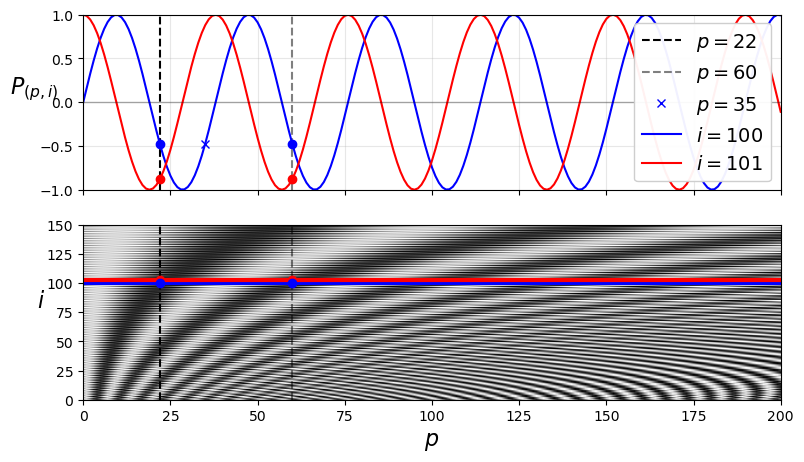

In [33]:
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()